<img src="https://uk-scape.ceh.ac.uk/sites/default/files/images/theme/UK_SCAPE_Logo_Positive_0.png" alt="image" align="left">

# Environment Agency (EA) water quality (WQ) data availability
This notebook demonstrates how to access regularly updated pre-processed files that summarise EA WQ monitoring sites, and metadata about the determinands measured at them. \
Then you can plot a timeseries of a determinand for a particular site using a standardised webservice. \
Node middleware defined below is https://eip.ceh.ac.uk/hydrology-ukscape/help.

## Import packages
Import required libraries for map and plots.

In [4]:
import urllib.request, json, pandas as pd, geopandas as gpd
from matplotlib import pyplot as matplt
import matplotlib.dates as mdate
# for map backgrounds
import contextily as cx 

## Functions you can call to retrieve and process data
(see below for an example comparing sites that are open)

**Function *get_wq_sites*:** Pass in parameters to filter the EA WQ sites and load them from the node middleware to geopandas dataframe. See further down for available list of parameters.

In [5]:
def get_wq_sites(options, show_details=True):
    if show_details:
        print(options)
    filtered = False
    #some kind of geometry / filter must be passed in otherwise the middleware will error.
    if options.get('latitude') != None and options.get('longitude') != None:
        filtered = True
    if options.get('easting') != None and options.get('easting') != None:
        filtered = True
    if options.get('HAs') != None:
        if len(options['HAs']) > 0:
            filtered = True
    if options.get('siteIDs') != None:
        if len(options['siteIDs']) > 0:
            filtered = True
    if options.get('determinands') != None:
        if len(options['determinands']) > 0:
            filtered = True
    if show_details:
        print('filters applied', filtered)
    # generate the url to pass to the middleware
    if filtered == True:
        #baseUrl
        url = "https://eip.ceh.ac.uk/hydrology-ukscape/WQdataAvailability?"

        #build url based on passed in options
        if options.get('startYear') != None:
            url +='&startYear='+str(options['startYear'])

        if options.get('endYear') != None:
            url +='&endYear='+str(options['endYear'])

        if options.get('siteIDs') != None:
            if len(options['siteIDs']) > 0:
                url +='&siteIDs='+",".join(options['siteIDs'])

        if options.get('determinands') != None:
            if len(options['determinands']) > 0:
                url += "&determinands="+",".join(options['determinands'])
                
        if options.get('latitude') != None:
            url +='&latitude='+str(options['latitude'])

        if options.get('longitude') != None:
            url +='&longitude='+str(options['longitude'])

        if options.get('easting') != None:
            url +='&easting='+str(options['easting'])

        if options.get('northing') != None:
            url +='&northing='+str(options['northing'])

        if options.get('distMetres') != None:
            url +='&distMetres='+str(options['distMetres'])

        if options.get('minNumMeasurements') != None:
            url +='&minNumMeasurements='+str(options['minNumMeasurements'])

        if options.get('HAs') != None:
            if len(options['HAs']) > 0:
                url += "&HAs="+",".join(options['HAs'])

        if options.get('siteType') != None:
            url += "&siteType="+str(options['siteType'])
        #if show_details:
        print('url',url)
        #use request library to get the data from the node middleware
        try:
            with urllib.request.urlopen(url) as response:
                data = json.load(response)
                #use normalize to flatten the nested response
                rivers = pd.json_normalize(data['rivers']['sites'])
                lakes = pd.json_normalize(data['lakes']['sites'])
                #convert normal pandas to geopandas dataframes
                if len(rivers) > 0:
                    riversGDF = gpd.GeoDataFrame(rivers, crs='epsg:4326', geometry=gpd.points_from_xy(rivers['properties.lon'],rivers['properties.lat']))
                else:
                    riversGDF = gpd.GeoDataFrame() 
                if len(lakes) > 0:
                    lakesGDF = gpd.GeoDataFrame(lakes, crs='epsg:4326', geometry=gpd.points_from_xy(lakes['properties.lon'],lakes['properties.lat']))
                else:
                    lakesGDF = gpd.GeoDataFrame() 
                if show_details:
                    print(riversGDF.head(5))
                    print(lakesGDF.head(5))
                #create a dictionary of the lakes and rivers for use throughout the program.
                sites = {
                   'lakes':lakesGDF,
                   'rivers':riversGDF,
                }
                return sites
        except urllib.error.HTTPError as e:
            print(e.code)
            print('No sites available for this query.')
    else:
        print('Please add some filters to limit the query.')

**Function *get_timeseries_data*:** Get timeseries data for a given site ID. Calls *get_determinands_for_site* to see which determinands are measured at that site, then you can choose a determinand ID to plot a timeseries using *fetch_timeseries_data*.

In [6]:
def get_timeseries_data(site_id):
    #get a list of available determinands for the given site
    determinands = get_determinands_for_site(site_id)
    timeseries_df = None
    determinand = dict()
    print('ts data ftn')
    # get the timeseries data by inputting a site ID from the site list 
    # choose a determinand ID (the 'notation' of the determinand from the list)
    if len(determinands) > 0:
        determinand_id = input('Choose determinand ID from list')
        determinand = determinands.query('notation == @determinand_id')
        if len(determinand) == 1:
            print('Site ID: '+site_id)
            print('Determinand: '+str(determinand.iloc[0]))
            timeseries_df = fetch_timeseries_data(site_id, determinand_id)
    return {'data':timeseries_df, 'determinand':determinand.iloc[0]}

**Function *get_determinands_for_site*:** Get all determinands for a specific site ID in order to see which determinands are available.

In [7]:
def get_determinands_for_site(site_id):
    # Call the EA API directly here so get the most up to date information.
    siteUrl = "https://environment.data.gov.uk/water-quality/id/sampling-point/"+site_id+"/determinands.json"
    print('site URL', siteUrl)
    determinands = None
    try:
        #fetch the data
        with urllib.request.urlopen(siteUrl) as response:
            data = json.load(response)
            #print(data)
            determinands = pd.json_normalize(data['items'])
            print('Determinands for site', determinands.head(5))
            #for item in data['items']:
             #   print('Name: '+item['definition']+', ID: '+item['notation'] + ', units: '+item['unit']['label'])
            return determinands
    except:
        print('Error, cannot fetch determinands, or no determinands for ID.')

**Function *fetch_timeseries_data*:** Get the timeseries data of a site by its reference. \
See http://eip.ceh.ac.uk/hydrology-ukscape/help for all available parameter combinations.

In [8]:
def fetch_timeseries_data(site_id, determinand_id):
    #print(determinand_id)
    #get the data from node middleware as csv
    timeseries_url = 'http://eip.ceh.ac.uk/hydrology-ukscape/stations/EA/WQ/'+str(site_id)+'?determinand='+str(determinand_id)
    print('Timeseries URL',timeseries_url)
    timeseries_df = None
    try:
        with urllib.request.urlopen(timeseries_url) as response:
        #read json into dataframe
            data = json.load(response)
            timeseries_df = pd.json_normalize(data['data']);
            print('timeseries',timeseries_df.head(1))
            return timeseries_df
    except urllib.error.HTTPError as e:
        print(e.code)
        print('No timeseries data available for this query.')  

Draw a mapplotlib plot of timeseries data for specific site.

In [9]:
def draw_Matplt_Plot(site_id, detStruct, df):
    fig = matplt.figure(figsize=(12,8))
    matplt.plot(df['datetime'], df['value'])
    matplt.xlabel('Date')
    matplt.ylabel(detStruct['unit.label'])
    matplt.title(detStruct['label'] + ' for ' + str(site_id))
    matplt.grid()
    matplt.xticks(rotation=45)
    #only show months on xaxis ticks
    locator = mdate.YearLocator()
    matplt.gca().xaxis.set_minor_locator(locator)
    matplt.show()

## Available parameters for retrieving EA WQ site data
Any combination of these options (must be latitude *and* longitude, or easting *and* northing, or HAs (Hydrological Area), or siteIDs): \
options = { \
    'startYear': 2013, \
    'endYear': 2017, \
    'siteIDs': ['SO-Y0004402','NW-88021734'], \
    'determinands': ['0117','0180'], #nitrate, orthophosphate \
    'latitude': 55.435895119108686, \
    'longitude': -1.7834570761075501, \
    'easting':413800, \
    'northing':615800, \
    'distMetres': 1000, \
    'minNumMeasurements': 20, \
    'HAs':['21','22'], \
    'siteType': 'rivers' or 'lakes' \
}

## Example: comparing sites that are open 
This example shows all sites that are open and have measured more than 20 samples of both nitrate and phosphate in different time periods (2013-2017, 2018-2021, and 2017-2022). 

{'startYear': 2013, 'endYear': 2017, 'determinands': ['0117', '0180'], 'minNumMeasurements': 20}
filters applied True
url https://eip.ceh.ac.uk/hydrology-ukscape/WQdataAvailability?&startYear=2013&endYear=2017&determinands=0117,0180&minNumMeasurements=20
      type properties.site_id                  properties.site_name  \
0  Feature        NE-41000232  NORTH LOW OPP SHEEPFOLD N OF GOSWICK   
1  Feature        NE-41000412              WILLOW BURN AT THE B6350   
2  Feature        NE-49000021            COMMONDALE BECK D/S OF STW   
3  Feature        NE-49100231                FOX DIKE AT FOX BRIDGE   
4  Feature        NE-49100565       SANDWATH BECK AT LINTON-ON-OUSE   

   properties.easting  properties.northing  properties.min_year  \
0              405478               645356                 2015   
1              385715               638986                 2013   
2              466399               510095                 2013   
3              453864               433915        

Text(0.5, 1.0, 'N&P sites open between 2017-2022')

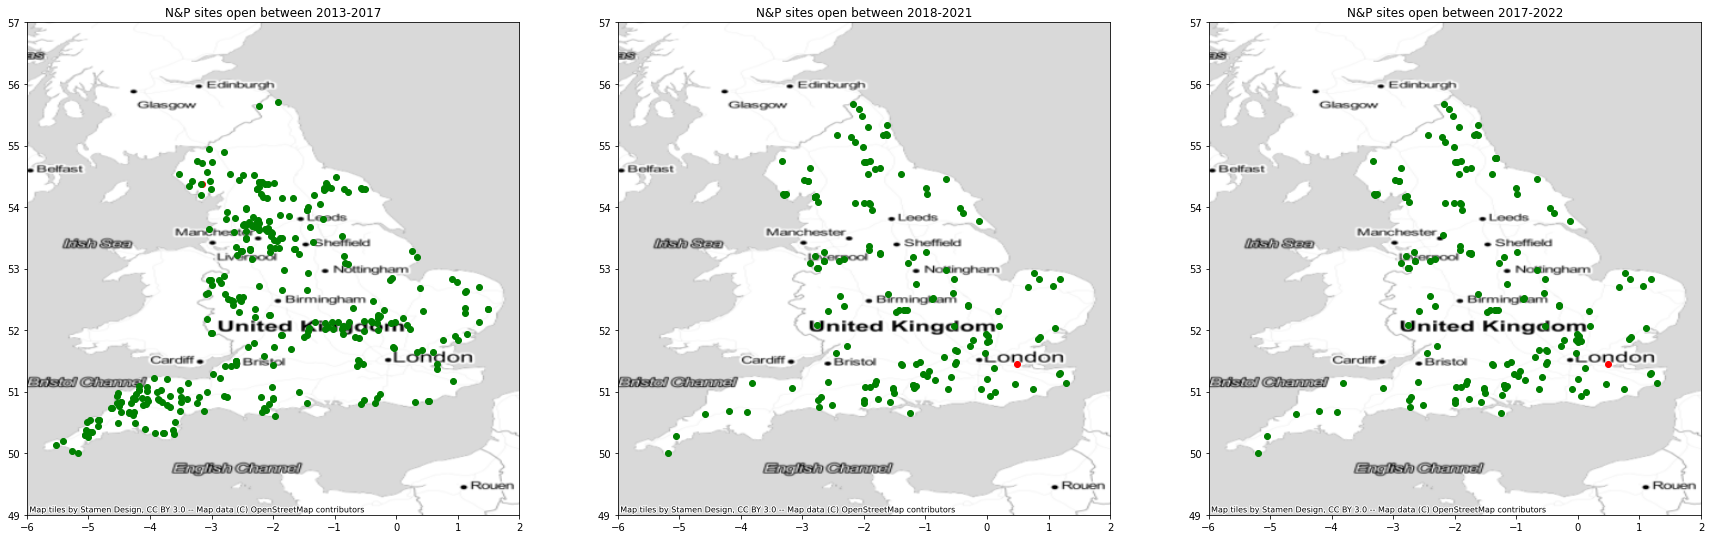

In [10]:
fig, (ax1,ax2,ax3) = matplt.subplots(1,3, figsize=(30,10))

#sites open between 2013 and 2017
ax1_options = {
    'startYear': 2013,
    'endYear': 2017,
    'determinands': ['0117','0180'], #nitrate, orthophosphate
    'minNumMeasurements': 20
}
ax1_sites = get_wq_sites(ax1_options) #show_details will toggle viewing the data, etc
#plot sites on matplotlib
ax1_sites['lakes'].plot(ax=ax1, color='red')
ax1_sites['rivers'].plot(ax=ax1, color='green')
ax1.set_xlim([-6,2])
ax1.set_ylim([49,57])
cx.add_basemap(ax1, zoom=6, crs="epsg:4326", source=cx.providers.Stamen.TonerLite)
ax1.set_title('N&P sites open between 2013-2017')

#sites open between 2018 and 2021
ax2_options = {
    'startYear': 2018,
    'endYear': 2021,
    'determinands': ['0117','0180'], 
    'minNumMeasurements': 20
}
ax2_sites = get_wq_sites(ax2_options, show_details=False) 
ax2_sites['lakes'].plot(ax=ax2, color='red')
ax2_sites['rivers'].plot(ax=ax2, color='green')
ax2.set_xlim([-6,2])
ax2.set_ylim([49,57])
cx.add_basemap(ax2, zoom=6, crs="epsg:4326", source=cx.providers.Stamen.TonerLite)
ax2.set_title('N&P sites open between 2018-2021')

#sites open between 2017 and 2022
ax3_options = {
    'startYear': 2017,
    'endYear': 2022,
    'determinands': ['0117','0180'], 
    'minNumMeasurements': 20
}
ax3_sites = get_wq_sites(ax3_options, show_details=False) 
#plot sites on matplotlib
ax3_sites['lakes'].plot(ax=ax3, color='red')
ax3_sites['rivers'].plot(ax=ax3, color='green')
ax3.set_xlim([-6,2])
ax3.set_ylim([49,57])
cx.add_basemap(ax3, zoom=6, crs="epsg:4326", source=cx.providers.Stamen.TonerLite)
ax3.set_title('N&P sites open between 2017-2022')

## Plot WQ timeseries data
Fetch the timeseries data for the chosen site. \
Type in a site ID, e.g. NE-41000232, which will fetch the timeseries data for Ammonia (in this example) for this site.

Site ID NE-41000232


site URL https://environment.data.gov.uk/water-quality/id/sampling-point/NE-41000232/determinands.json
Determinands for site                                                  @id  \
0  http://environment.data.gov.uk/water-quality/d...   
1  http://environment.data.gov.uk/water-quality/d...   
2  http://environment.data.gov.uk/water-quality/d...   
3  http://environment.data.gov.uk/water-quality/d...   
4  http://environment.data.gov.uk/water-quality/d...   

                      definition         label notation  \
0  Orthophosphate, reactive as P  Orthophospht     0180   
1  Alkalinity to pH 4.5 as CaCO3   Alky pH 4.5     0162   
2           Temperature of Water    Temp Water     0076   
3           Conductivity at 25 C    Cond @ 25C     0077   
4       Ammoniacal Nitrogen as N    Ammonia(N)     0111   

                                            unit.@id  \
0  http://environment.data.gov.uk/water-quality/d...   
1  http://environment.data.gov.uk/water-quality/d...   
2  http://envir

Choose determinand ID from list 0162


Site ID: NE-41000232
Determinand: @id             http://environment.data.gov.uk/water-quality/d...
definition                          Alkalinity to pH 4.5 as CaCO3
label                                                 Alky pH 4.5
notation                                                     0162
unit.@id        http://environment.data.gov.uk/water-quality/d...
unit.comment                                  MILLIGRAM PER LITRE
unit.label                                                   mg/l
Name: 1, dtype: object
Timeseries URL http://eip.ceh.ac.uk/hydrology-ukscape/stations/EA/WQ/NE-41000232?determinand=0162
timeseries    value             datetime           materialType  \
0    216  2014-06-18T12:15:00  FINAL SEWAGE EFFLUENT   

                                                  id  \
0  http://environment.data.gov.uk/water-quality/d...   

                     determinand units  \
0  Alkalinity to pH 4.5 as CaCO3  mg/l   

                                             purpose  
0  ENV

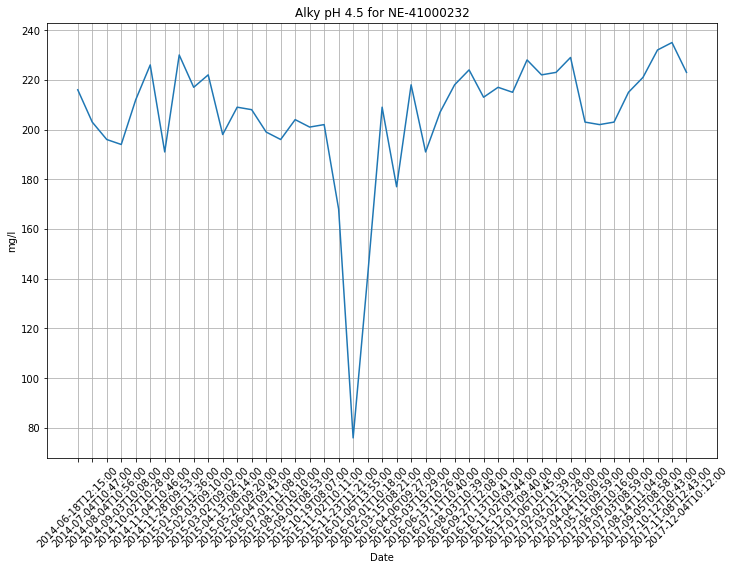

In [12]:
site_ID = input('Site ID')
ts_data = get_timeseries_data(site_ID)
if (ts_data['data'] is not None and len(ts_data['data']) > 0):
    #if mapplotlib available
    draw_Matplt_Plot(site_ID, ts_data['determinand'], ts_data['data'])
else:
    print('No ' +ts_data['determinand']['id']+ ' timeseries data available for ' + str(site_ID))